Required libraries:

In [28]:
import cubo
import spyndex
from sen2nbar.nbar import nbar_cubo

import xarray as xr
import numpy as np

Retrieve an AI-Focused data cube of Sentinel-2:

In [29]:
da = cubo.create(
    lat=51.079225, # Central latitude of the cube
    lon=10.452173, # Central longitude of the cube
    collection="sentinel-2-l2a", # Name of the STAC collection
    bands=["B04","B05","B06","B07","B08"], # Bands to retrieve
    start_date="2016-06-01", # Start date of the cube
    end_date="2017-07-01", # End date of the cube
    edge_size=512, # Edge size of the cube (px)
    resolution=10, # Pixel size of the cube (m)
    query={"eo:cloud_cover": {"lt": 10}} # kwarg to pass
)

/net/home/dmontero/.conda/envs/helios/lib/python3.10/site-packages/stackstac/prepare.py:364: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Check the cube, it is a "lazy" data cube. This means data has not been downloaded and it will be done just when data is requested.

In [30]:
da

<xarray.DataArray 'sentinel-2-l2a' (time: 18, band: 5, y: 512, x: 512)>
dask.array<fetch_raster_window, shape=(18, 5, 512, 512), dtype=float64, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2016-06-24...
    id                                       (time) <U54 'S2A_MSIL2A_20160624...
  * band                                     (band) <U3 'B04' 'B05' ... 'B08'
  * x                                        (x) float64 5.992e+05 ... 6.043e+05
  * y                                        (y) float64 5.662e+06 ... 5.657e+06
    s2:unclassified_percentage               (time) float64 0.2548 ... 0.2896
    ...                                       ...
    gsd                                      (band) float64 10.0 20.0 ... 10.0
    common_name                              (band) <U7 'red' ... 'nir'
    center_wavelength                        (band) float64 0.665 ... 0.842
    full_width_half_max                      (band) float64 0.038 ... 0.145
    epsg                                     int64 32632
    cubo:distance_from_center                (y, x) float64 3.623e+03 ... 3.6...
Attributes:
    collection:           sentinel-2-l2a
    stac:                 https://planetarycomputer.microsoft.com/api/stac/v1
    epsg:                 32632
    resolution:           10
    edge_size:            512
    central_lat:          51.079225
    central_lon:          10.452173
    central_y:            5659638.0946523
    central_x:            601722.4825156148
    time_coverage_start:  2016-06-01
    time_coverage_end:    2017-07-01

Request the data:

In [31]:
da = da.compute()

Plot the NIR band, just to check:

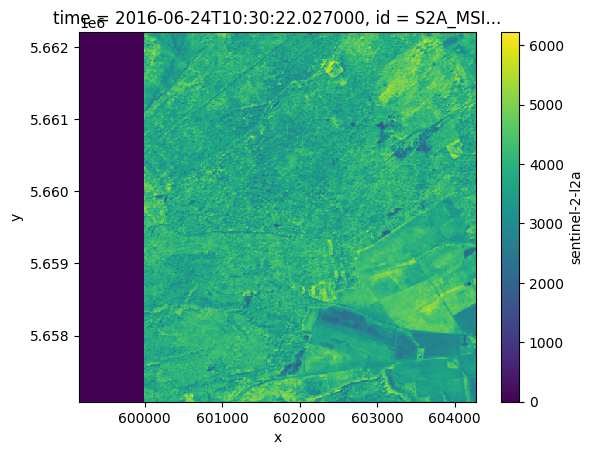

In [33]:
da.isel(time=0).sel(band="B08").plot.imshow()

Note there is a zero stripe to the left, this is not part of the tile. Zero should be nan:

In [34]:
da = da.where(lambda x: x != 0, other = np.nan)

Now we check again:

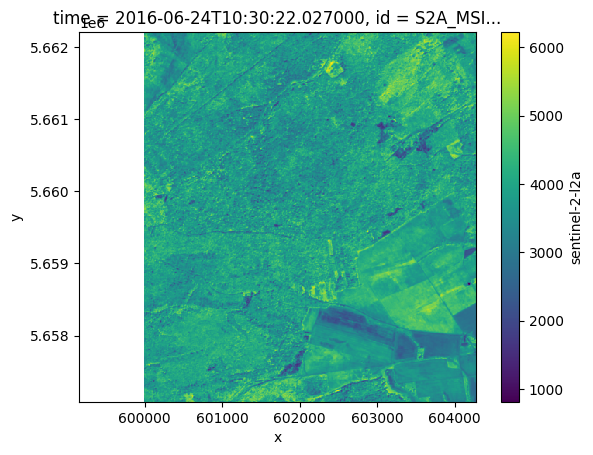

In [36]:
da.isel(time=0).sel(band="B08").plot.imshow()

Correct by BRDF effects (Data must be in [0,10000]). This function also harmonizes data after Feb 2022:

In [37]:
da_nbar = nbar_cubo(da)

Scale to [0,1]:

In [38]:
da_nbar = da_nbar/10000

We check the data again:

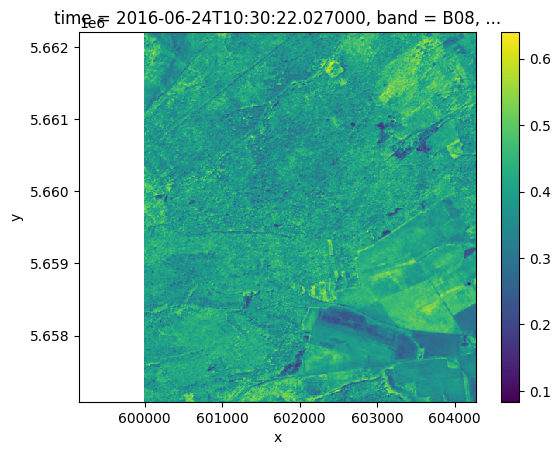

In [39]:
da_nbar.isel(time=0).sel(band="B08").plot.imshow()

Compute spectral indices:

In [40]:
idx = spyndex.computeIndex(
    index = ["NDVI","NIRv","IRECI","CIRE"],
    R = da_nbar.sel(band="B04"),
    RE1 = da_nbar.sel(band="B05"),
    RE2 = da_nbar.sel(band="B06"),
    RE3 = da_nbar.sel(band="B07"),
    N = da_nbar.sel(band="B08"),
)

Check the cube, now it has a new dimension called index:

In [41]:
idx

<xarray.DataArray (index: 4, time: 18, y: 512, x: 512)>
array([[[[       nan,        nan,        nan, ..., 0.8640854 ,
          0.8362381 , 0.8425196 ],
         [       nan,        nan,        nan, ..., 0.86900896,
          0.8307612 , 0.8002448 ],
         [       nan,        nan,        nan, ..., 0.8649081 ,
          0.86478114, 0.81798023],
         ...,
         [       nan,        nan,        nan, ..., 0.62657595,
          0.48003167, 0.45268553],
         [       nan,        nan,        nan, ..., 0.67772925,
          0.52355075, 0.4661206 ],
         [       nan,        nan,        nan, ..., 0.7214294 ,
          0.5848163 , 0.4722775 ]],

        [[0.90921485, 0.91397214, 0.91588855, ..., 0.87282634,
          0.84514624, 0.85083777],
         [0.9082257 , 0.91155565, 0.9088594 , ..., 0.87721175,
          0.8400002 , 0.8079944 ],
         [0.90618837, 0.91421497, 0.91360635, ..., 0.87320846,
          0.87329525, 0.8256848 ],
...
         [       nan,        nan,        nan, ..., 1.5095463 ,
          1.6651146 , 1.6617856 ],
         [       nan,        nan,        nan, ..., 1.5459306 ,
          1.5847299 , 1.5847502 ],
         [       nan,        nan,        nan, ..., 1.6304162 ,
          1.6227162 , 1.6293433 ]],

        [[4.857279  , 4.7276306 , 5.0972614 , ..., 2.5690181 ,
          2.441445  , 2.6734033 ],
         [4.3433194 , 4.2460837 , 4.291329  , ..., 2.7710085 ,
          2.3716786 , 2.2566617 ],
         [4.473472  , 4.544293  , 4.754614  , ..., 2.9669735 ,
          2.7201335 , 2.2600193 ],
         ...,
         [5.4369173 , 5.44996   , 5.5205293 , ..., 1.508739  ,
          1.6690693 , 1.662384  ],
         [3.876493  , 4.652228  , 4.9841433 , ..., 1.540216  ,
          1.5831189 , 1.584791  ],
         [4.3237915 , 5.474881  , 5.378275  , ..., 1.6261876 ,
          1.6244092 , 1.6194751 ]]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2016-06-24T10:30:22.027000 ... 2017-06-19T...
  * x        (x) float64 5.992e+05 5.992e+05 5.992e+05 ... 6.043e+05 6.043e+05
  * y        (y) float64 5.662e+06 5.662e+06 5.662e+06 ... 5.657e+06 5.657e+06
  * index    (index) <U5 'NDVI' 'NIRv' 'IRECI' 'CIRE'
Attributes:
    collection:           sentinel-2-l2a
    stac:                 https://planetarycomputer.microsoft.com/api/stac/v1
    epsg:                 32632
    resolution:           10
    edge_size:            512
    central_lat:          51.079225
    central_lon:          10.452173
    central_y:            5659638.0946523
    central_x:            601722.4825156148
    time_coverage_start:  2016-06-01
    time_coverage_end:    2017-07-01

Plot indices:

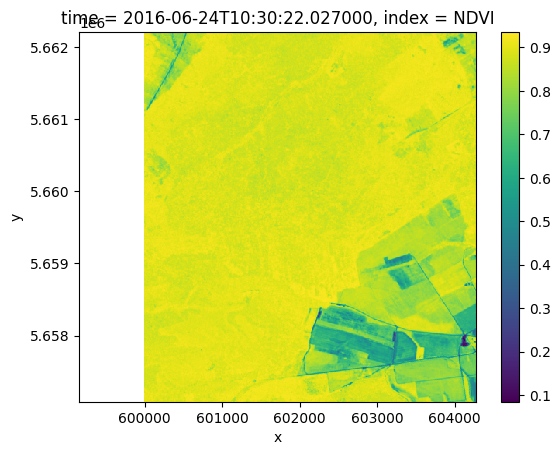

In [43]:
idx.isel(time=0).sel(index="NDVI").plot.imshow()

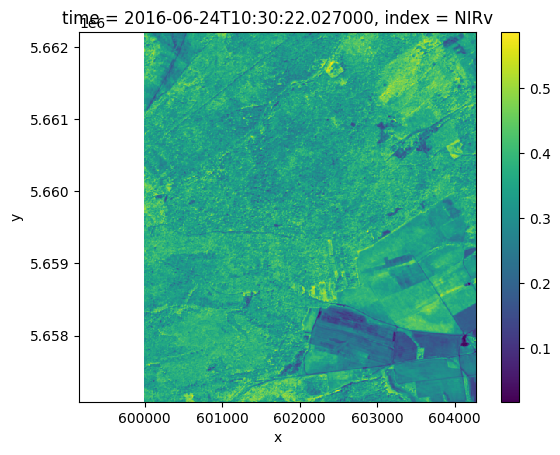

In [44]:
idx.isel(time=0).sel(index="NIRv").plot.imshow()

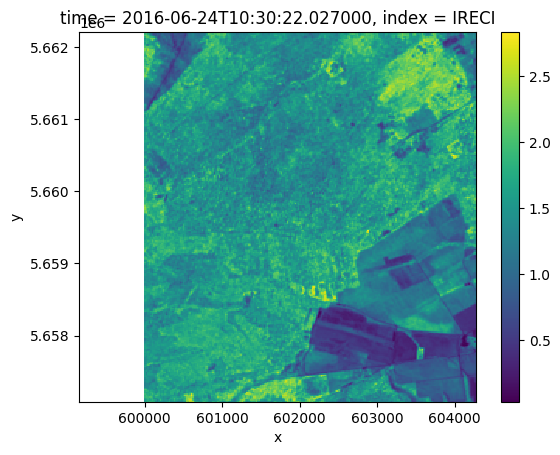

In [45]:
idx.isel(time=0).sel(index="IRECI").plot.imshow()

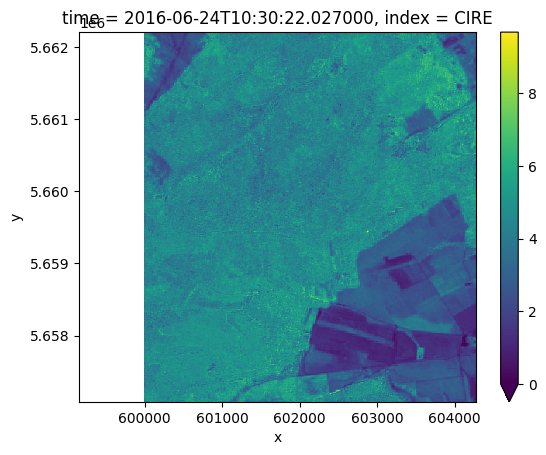

In [48]:
idx.isel(time=0).sel(index="CIRE").plot.imshow(vmin=0)